In [10]:
# Importing libraries

import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from collections.abc import Mapping

In [11]:
# Get the device
def_device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Function to send data to device
def to_device(x, device=def_device):
    if isinstance(x, torch.Tensor): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

In [12]:
# Load the datasets

batch_size = 256

train_ds = torchvision.datasets.FashionMNIST(root = './data/train',train = True,download = True,transform = T.ToTensor())
valid_ds = torchvision.datasets.FashionMNIST(root = './data/valid',train = False,download = True,transform = T.ToTensor())

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

## Autoencoder

In [13]:
# Define the autoencoder model
# Using SiLU activation function
# Using BatchNorm1d
# Using nn.Flatten() and nn.Unflatten() to flatten and unflatten the images
# Using a simple MultiLayerPerceptron as the encoder and decoder as the images are small
# Defined the encoder and decoder as sequential layers
# Defined the forward function

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,200),
                                    nn.BatchNorm1d(200),
                                    nn.SiLU())
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        return self.decoder(self.encoder(x))

In [14]:
# Create the model and send it to device

model = AutoEncoder().to(def_device)

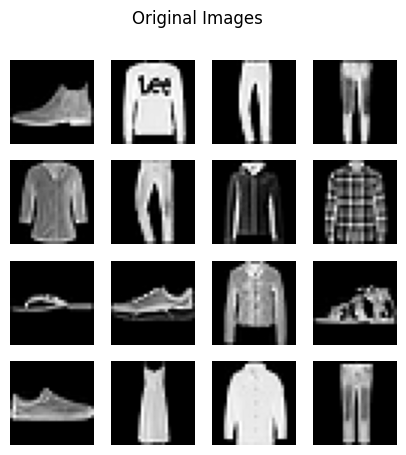

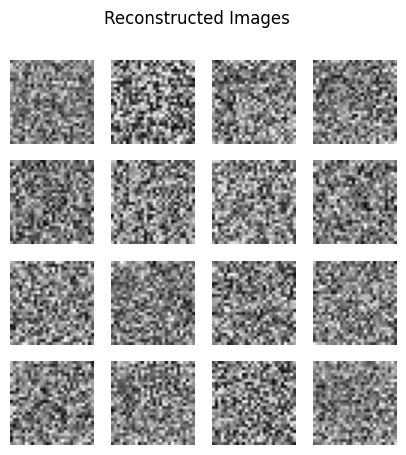

In [15]:
# Look at the predictions of the model before training

batch = next(iter(valid_dl))
images,labels = batch
batch = to_device(batch)
preds = model(batch[0]).detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [16]:
# Define the hyperparameters
# Using Adam optimizer
# Using OneCycleLR scheduler

epochs = 20
lr = 3e-2
opt = optim.Adam(model.parameters(),lr = lr, eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt,max_lr = lr,epochs = epochs,steps_per_epoch = len(train_dl))

In [17]:
# Train the model
# Using binary cross entropy loss

for epoch in range(epochs):
    losses = []
    model.train()
    for batch in train_dl:
        batch = to_device(batch)
        images,labels = batch
        preds = model(images)
        loss = F.binary_cross_entropy_with_logits(preds,images)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        sched.step()
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(losses):.4f}")
    losses = []
    model.eval()
    for batch in valid_dl:
        batch = to_device(batch)
        images,labels = batch
        preds = model(images)
        loss = F.binary_cross_entropy_with_logits(preds,images)
        losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Valid Loss: {np.mean(losses):.4f}")

Epoch [1/20], Train Loss: 0.5303
Epoch [1/20], Valid Loss: 0.4660
Epoch [2/20], Train Loss: 0.4013
Epoch [2/20], Valid Loss: 0.3479
Epoch [3/20], Train Loss: 0.3168
Epoch [3/20], Valid Loss: 0.3007
Epoch [4/20], Train Loss: 0.2867
Epoch [4/20], Valid Loss: 0.2829
Epoch [5/20], Train Loss: 0.2760
Epoch [5/20], Valid Loss: 0.2754
Epoch [6/20], Train Loss: 0.2711
Epoch [6/20], Valid Loss: 0.2722
Epoch [7/20], Train Loss: 0.2683
Epoch [7/20], Valid Loss: 0.2690
Epoch [8/20], Train Loss: 0.2663
Epoch [8/20], Valid Loss: 0.2695
Epoch [9/20], Train Loss: 0.2651
Epoch [9/20], Valid Loss: 0.2665
Epoch [10/20], Train Loss: 0.2641
Epoch [10/20], Valid Loss: 0.2644
Epoch [11/20], Train Loss: 0.2632
Epoch [11/20], Valid Loss: 0.2647
Epoch [12/20], Train Loss: 0.2625
Epoch [12/20], Valid Loss: 0.2631
Epoch [13/20], Train Loss: 0.2620
Epoch [13/20], Valid Loss: 0.2626
Epoch [14/20], Train Loss: 0.2613
Epoch [14/20], Valid Loss: 0.2620
Epoch [15/20], Train Loss: 0.2609
Epoch [15/20], Valid Loss: 0.261

In [18]:
# Save the model

# model = model.cpu()
# torch.save(model,'autoencoder.pth')

In [19]:
# Load the model

model = torch.load('autoencoder.pth')

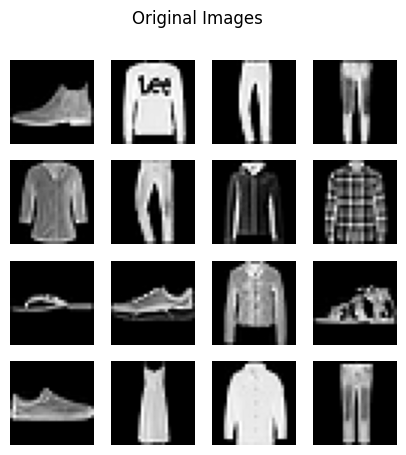

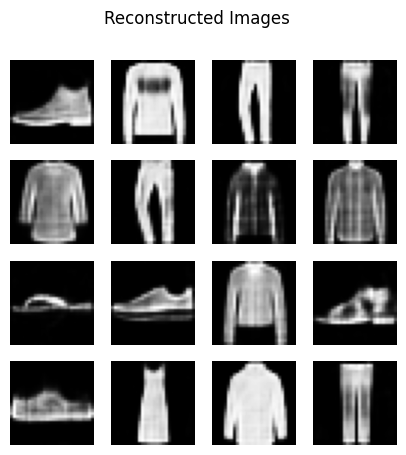

In [20]:
# Look at the predictions of the model after training

batch = next(iter(valid_dl))
preds = model(batch[0]).detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

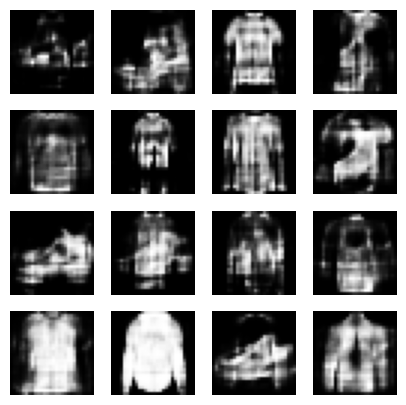

In [21]:
# Try to generate new images from random noise
# As the model is trained to reconstruct the images, it is not able to generate new images from random noise

random_noise = torch.randn(16,1,28,28)
preds = model(random_noise).detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

## VAE

In [22]:
# Define the variational autoencoder model
# Using the same encoder and decoder as the autoencoder except for the last layer of the encoder
# The last layer of the encoder outputs the mean and log variance of the latent space
# The forward function returns the reconstructed image, mean and log variance of the latent space

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU())
        
        self.mu = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))

        self.logvar = nn.Sequential(nn.Linear(400,200),nn.BatchNorm1d(200))
        
        self.decoder = nn.Sequential(nn.Linear(200,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,400),
                                    nn.BatchNorm1d(400),
                                    nn.SiLU(),
                                    nn.Linear(400,784),
                                    nn.BatchNorm1d(784),
                                    nn.Unflatten(1,(1,28,28)))
    def forward(self,x):
        x = self.encoder(x)
        mu = self.mu(x)
        logvar = self.logvar(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu + eps*std
        return self.decoder(z),mu,logvar

In [23]:
# Define the variational autoencoder loss functions
# Using binary cross entropy loss for the reconstruction loss
# Using KL divergence loss for the KL divergence loss
# The total loss is the sum of the reconstruction loss and the KL divergence loss

def KLDivergence_loss(input, target):
    _ , mu, logvar = input
    KLD = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp()).mean()
    return KLD

def BCE_loss(input, target):
    BCE = F.binary_cross_entropy_with_logits(input[0], target)
    return BCE

def vae_loss_func(input, target):
    BCE = BCE_loss(input, target)
    KLD = KLDivergence_loss(input, target)
    return BCE + KLD

In [24]:
# Create the model and send it to device

model = VAE().to(def_device)

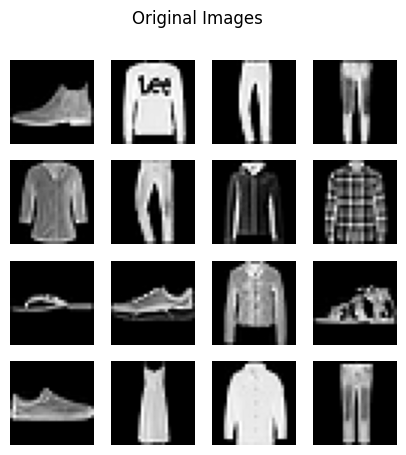

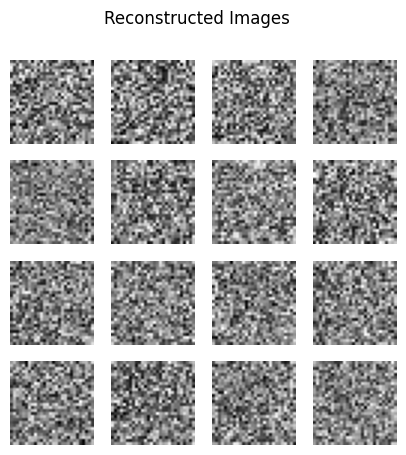

In [25]:
# Look at the predictions of the model before training

batch = next(iter(valid_dl))
images,labels = batch
batch = to_device(batch)
preds = model(batch[0])[0].detach().cpu().sigmoid()
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

In [26]:
# Define the hyperparameters
# Using Adam optimizer
# Using OneCycleLR scheduler

epochs = 20
lr = 3e-2
opt = optim.Adam(model.parameters(),lr = lr, eps = 1e-5)
sched = optim.lr_scheduler.OneCycleLR(opt,max_lr = lr,epochs = epochs,steps_per_epoch = len(train_dl))

In [27]:
# Train the model

for epoch in range(epochs):
    kld_losses = []
    bce_losses = []
    losses = []
    model.train()
    for batch in train_dl:
        batch = to_device(batch)
        images,labels = batch
        preds = model(images)
        kld_loss = KLDivergence_loss(preds,images)
        kld_losses.append(kld_loss.item())
        bce_loss = BCE_loss(preds,images)
        bce_losses.append(bce_loss.item())
        loss = vae_loss_func(preds,images)
        losses.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()
        sched.step()
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {np.mean(losses):.4f}, KLD Loss: {np.mean(kld_losses):.4f}, BCE Loss: {np.mean(bce_losses):.4f}")
    kld_losses = []
    bce_losses = []
    losses = []
    model.eval()
    for batch in valid_dl:
        batch = to_device(batch)
        images,labels = batch
        preds = model(images)
        kld_loss = KLDivergence_loss(preds,images)
        kld_losses.append(kld_loss.item())
        bce_loss = BCE_loss(preds,images)
        bce_losses.append(bce_loss.item())
        loss = vae_loss_func(preds,images)
        losses.append(loss.item())
    print(f"Epoch [{epoch+1}/{epochs}], Valid Loss: {np.mean(losses):.4f}, KLD Loss: {np.mean(kld_losses):.4f}, BCE Loss: {np.mean(bce_losses):.4f}")

Epoch [1/20], Train Loss: 0.9768, KLD Loss: 0.4291, BCE Loss: 0.5477
Epoch [1/20], Valid Loss: 0.7534, KLD Loss: 0.2623, BCE Loss: 0.4911
Epoch [2/20], Train Loss: 0.5450, KLD Loss: 0.0989, BCE Loss: 0.4461
Epoch [2/20], Valid Loss: 0.4476, KLD Loss: 0.0389, BCE Loss: 0.4086
Epoch [3/20], Train Loss: 0.4173, KLD Loss: 0.0326, BCE Loss: 0.3847
Epoch [3/20], Valid Loss: 0.4001, KLD Loss: 0.0351, BCE Loss: 0.3650
Epoch [4/20], Train Loss: 0.3921, KLD Loss: 0.0342, BCE Loss: 0.3579
Epoch [4/20], Valid Loss: 0.3884, KLD Loss: 0.0371, BCE Loss: 0.3513
Epoch [5/20], Train Loss: 0.3838, KLD Loss: 0.0354, BCE Loss: 0.3484
Epoch [5/20], Valid Loss: 0.3824, KLD Loss: 0.0385, BCE Loss: 0.3438
Epoch [6/20], Train Loss: 0.3766, KLD Loss: 0.0346, BCE Loss: 0.3420
Epoch [6/20], Valid Loss: 0.3687, KLD Loss: 0.0321, BCE Loss: 0.3366
Epoch [7/20], Train Loss: 0.3617, KLD Loss: 0.0298, BCE Loss: 0.3319
Epoch [7/20], Valid Loss: 0.3565, KLD Loss: 0.0290, BCE Loss: 0.3275
Epoch [8/20], Train Loss: 0.3533, 

In [28]:
# Save the model

# model = model.cpu()
# torch.save(model,'VAE.pth')

In [29]:
# Load the model

model = torch.load('VAE.pth')

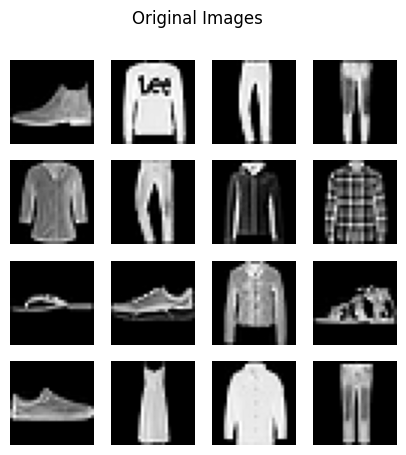

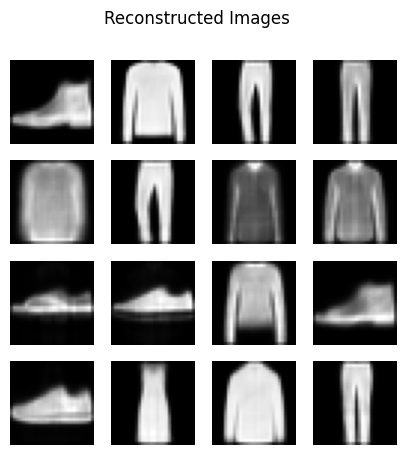

In [30]:
# Look at the predictions of the model after training

batch = next(iter(valid_dl))
preds = model(batch[0])[0].detach().cpu().sigmoid()
images,labels = batch
images = images[:16]
preds = preds[:16]

fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Original Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(images[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')
fig,ax = plt.subplots(4,4,figsize=(5,5))
fig.suptitle('Reconstructed Images')
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')

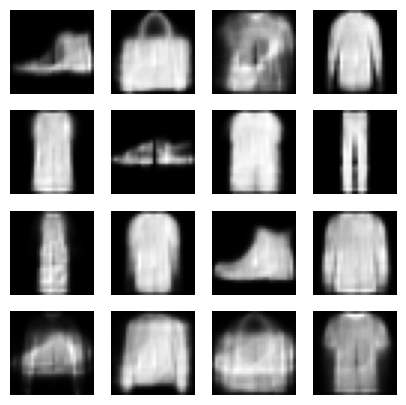

In [31]:
# Try to generate new images from random noise
# As you can see, the model is able to generate new images from random noise

random_noise = torch.randn(16,1,28,28)
preds = model(random_noise)[0].detach().cpu().sigmoid()
fig,ax = plt.subplots(4,4,figsize=(5,5))
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(preds[i*4+j][0],cmap='gray')
        ax[i,j].axis('off')